In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt


2023-11-22 16:04:42.556454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_august = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_08.csv')
df_september = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_09.csv')
df_october = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_10.csv')

In [3]:
df_august['Month'] = 0
df_september['Month'] = 1
df_october['Month'] = 2

In [4]:
frames = [df_august, df_september, df_october]
df = pd.concat(frames)

In [5]:
# Shape of dataframe
df.shape

(52592, 29)

saving 1/3 of original data for future

In [6]:
df_live, df_backup = train_test_split(df,test_size=0.3, random_state=42)
print(f'df_live.shape = {df_live.shape}')
print(f'df_backup.shape = {df_backup.shape}')

df_live.shape = (36814, 29)
df_backup.shape = (15778, 29)


Hierarchy of features:  1) squareMeters  2) Longitude  3) poiCount  4) rooms    5) centreDistance  6)clinicDistance  7) kindergardenDistance


Here is where we could do more data processing on df_live like selecting only numerical columns. If we wanted to look for missing values or repetitions then it's better to do it on Xn

In [7]:
num_cols = df_live.select_dtypes([np.number]).columns

df_nums = df_live[num_cols].reset_index(drop=True)
print(f'df_nums.shape = {df_nums.shape}')

df_nums.shape = (36814, 18)


In [8]:
X = df_nums.loc[:,df_nums.columns != 'price']
y = df_nums['price'].values

print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (36814, 17)
y.shape = (36814,)


In [9]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

print(type(X_normalized))
print(type(X_normalized_df))
print(type(X))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [10]:
selected_columns_2 = ['squareMeters', 'longitude']
selected_columns_3 = ['squareMeters', 'longitude', 'poiCount']
selected_columns_5 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance']
selected_columns_7 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance', 'clinicDistance', 'kindergartenDistance']

X2=X_normalized_df[selected_columns_2]
X3=X_normalized_df[selected_columns_3]
X5=X_normalized_df[selected_columns_5]
X7=X_normalized_df[selected_columns_7]

print(f'X2.shape = {X2.shape}')
print(f'X3.shape = {X3.shape}')
print(f'X5.shape = {X5.shape}')
print(f'X7.shape = {X7.shape}')

X2.shape = (36814, 2)
X3.shape = (36814, 3)
X5.shape = (36814, 5)
X7.shape = (36814, 7)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=42)
X1_train1, X1_validation, y1_train1, y1_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state=42)

print(f'X1_train1.shape = {X1_train1.shape}')
print(f'X1_validation.shape = {X1_validation.shape}')
print(f'X_test.shape = {X_test.shape}')


X1_train1.shape = (20615, 2)
X1_validation.shape = (8836, 2)
X_test.shape = (7363, 2)


In [12]:
# Define the neural network architecture
model = tf.keras.Sequential()

permutations = 3
num_iterations=3

model_struct=[]

rmse_matrix=np.zeros([3,num_iterations,permutations])

losses_per_permutation=[]
val_losses_per_permutation=[]
models=[]


for permutation in range(permutations):


  losses=[]
  val_losses=[]


  model.add(Dense(2, activation='relu', input_shape=(2,)))
  #model.add(Dense(permutation+2, activation='relu'))
  model.add(Dense(1, activation='relu'))

  model_struct.append([permutation+1,1])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





  for iteration in range(num_iterations):

    # Define a callback to collect training history
    history_callback = tf.keras.callbacks.History()

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',  # Monitor validation loss
      patience=5,  # Stop training if no improvement for 5 consecutive epochs
      restore_best_weights=True  # Restore model weights to the best observed during training
      )



    history = model.fit(X1_train1, y1_train1, epochs=50, validation_data=(X1_validation, y1_validation), callbacks=[early_stopping_callback])

    models.append(model)

    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])



    y_predict_train = model.predict(X1_train1)
    y_predict_val = model.predict(X1_validation)
    y_predict_test = model.predict(X_test)




    rmse_matrix[0,iteration,permutation]=np.sqrt(mean_squared_error(y1_train1, y_predict_train))
    rmse_matrix[1,iteration,permutation]=np.sqrt(mean_squared_error(y1_validation, y_predict_val))
    rmse_matrix[2,iteration,permutation]=np.sqrt(mean_squared_error(y_test, y_predict_test))

  losses_per_permutation.append(losses)
  val_losses_per_permutation.append(val_losses)





# Saving each model in the list to a directory
for i, model in enumerate(models):
    model.save(f'model_{i}.h5')  # Saving the model to disk with a unique filename


2023-11-22 16:04:55.844312: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
645/645 [==============================] - 4s 4ms/step - loss: -7715188.0000 - accuracy: 0.0000e+00 - val_loss: -10596383.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
645/645 [==============================] - 2s 4ms/step - loss: -10568596.0000 - accuracy: 0.0000e+00 - val_loss: -10606566.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
645/645 [==============================] - 3s 4ms/step - loss: -10583331.0000 - accuracy: 0.0000e+00 - val_loss: -10627384.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
645/645 [==============================] - 2s 2ms/step - loss: -10653736.0000 - accuracy: 0.0000e+00 - val_loss: -10785653.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
645/645 [==============================] - 1s 2ms/step - loss: -10759374.0000 - accuracy: 0.0000e+00 - val_loss: -10793927.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
645/645 [==============================] - 2s 3ms/step - loss: -10761638.0000 - accuracy: 0.0000e+00 - val_loss: -10793927.0000 - val_accuracy: 0.0000e+00
Epoch

In [14]:
num_models = permutation*num_iterations

loaded_models=[]

for i in range(num_models):
    loaded_model = tf.keras.models.load_model(f'model_{i}.h5')  # Load the model from disk
    loaded_models.append(loaded_model)

In [13]:
'''for i, history in enumerate(all_histories):
  print(f"Iteration {i+1} - Training Loss: {history.history['loss']}")
  training_loss_per_epoch = all_histories[i].history['loss']
  validation_loss_per_epoch = all_histories[i].history['val_loss']
  #loss_train, accuracy= model.evaluate(X1_train1, y1_train1)
  #loss_train, accuracy= model.evaluate(X1_train, y1_train)


  # Plot the accuracy values
  plt.plot(training_loss_per_epoch, 'b', label='Training loss '+str(i+1))
  plt.plot(validation_loss_per_epoch, 'r', label='Validation loss '+str(i+1))
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()

plt.show()
  # Evaluate the model on the test data
  #loss_test, accuracy_test.append = model.evaluate(X1_test, y1_test)'''

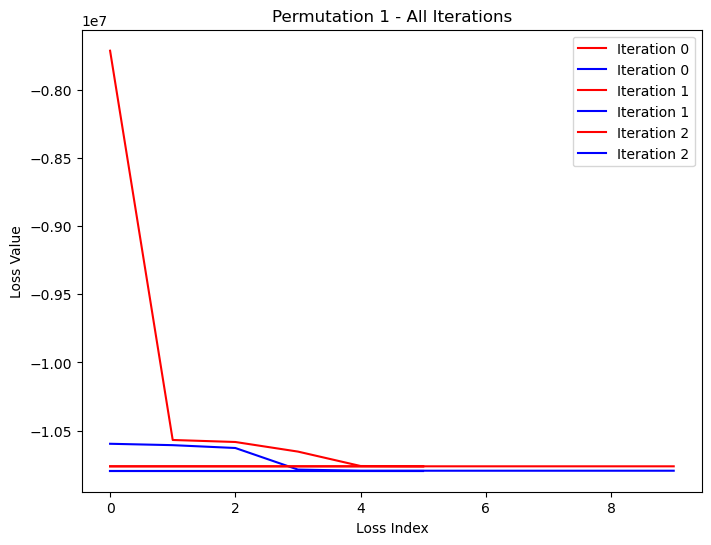

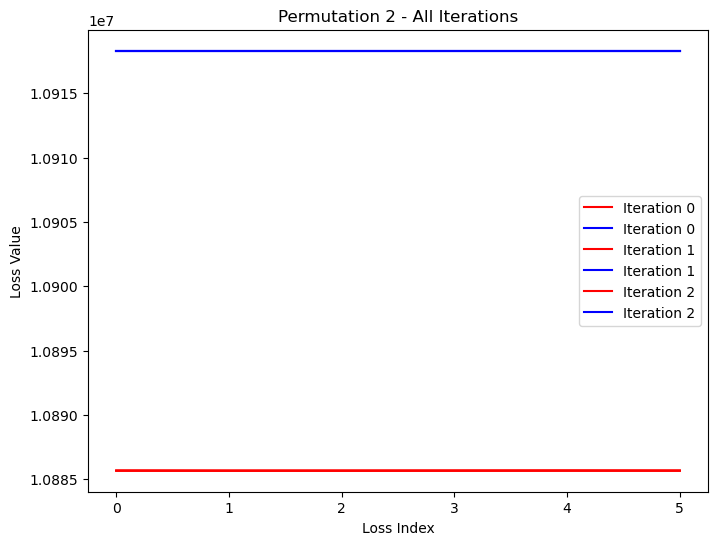

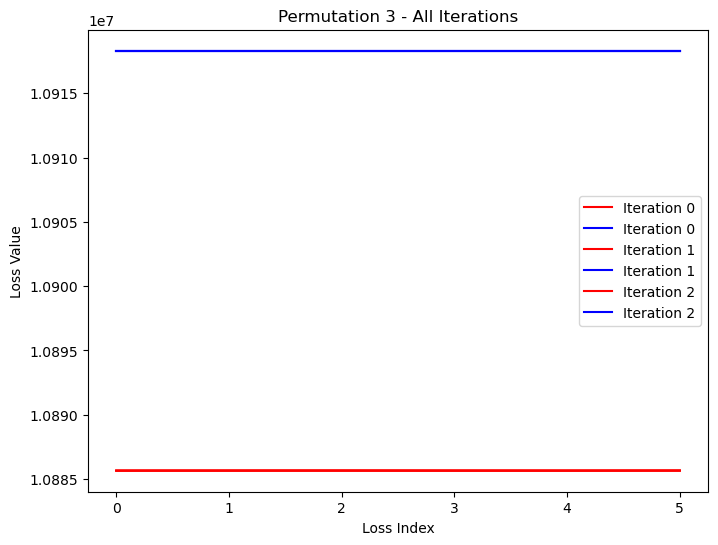

In [25]:
'''
# Plotting all iterations for each permutation on the same plot
for i, permutation_losses in enumerate(losses_per_permutation):
    plt.figure(figsize=(8, 6))
    count = 0
    for loss in permutation_losses:
        plt.plot(np.arange(len(loss)), loss, 'r', label=f'Iteration {count}')
        plt.plot(np.arange(len(val_losses_per_permutation[i][count])), val_losses_per_permutation[i][count], 'b', label=f'Iteration {count}')
        count += 1
    plt.xlabel('Loss Index')
    plt.ylabel('Loss Value')
    plt.title(f'Permutation {i+1} - All Iterations')
    plt.legend()
plt.show()

'''

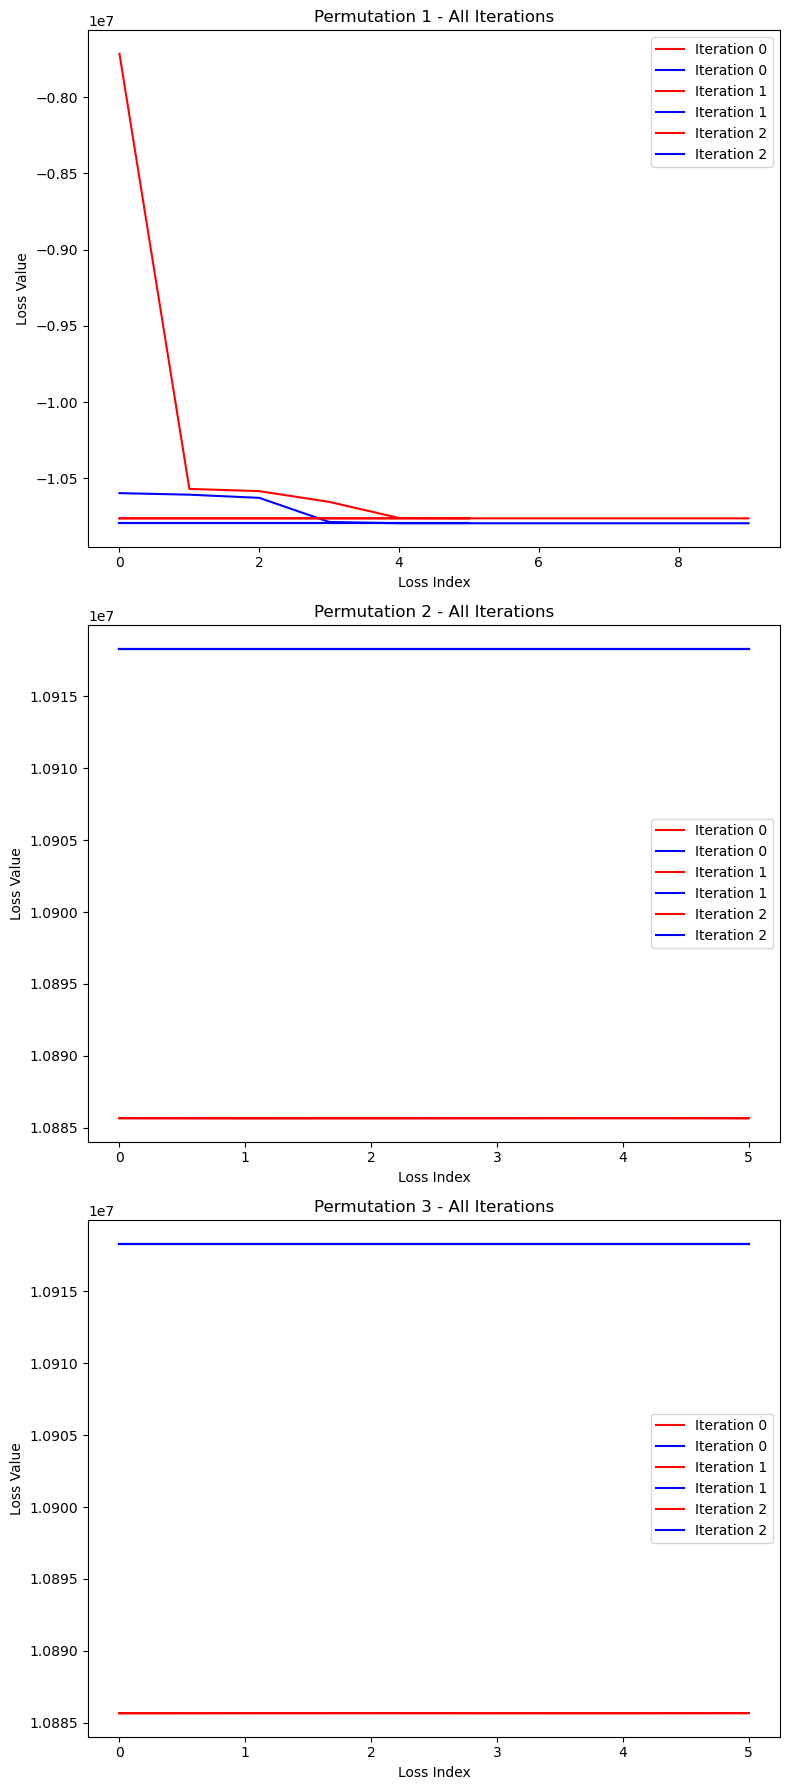

In [30]:
fig, axes = plt.subplots(len(losses_per_permutation), 1, figsize=(8, 6 * len(losses_per_permutation)))

# Plotting all iterations for each permutation as subplots
for i, permutation_losses in enumerate(losses_per_permutation):
    count = 0
    for loss in permutation_losses:
        axes[i].plot(np.arange(len(loss)), loss, 'r', label=f'Iteration {count}')
        axes[i].plot(np.arange(len(val_losses_per_permutation[i][count])), val_losses_per_permutation[i][count], 'b', label=f'Iteration {count}')
        count += 1
    
    axes[i].set_xlabel('Loss Index')
    axes[i].set_ylabel('Loss Value')
    axes[i].set_title(f'Permutation {i+1} - All Iterations')
    axes[i].legend()

plt.tight_layout()  # Adjust subplot parameters to fit into the figure
plt.show()


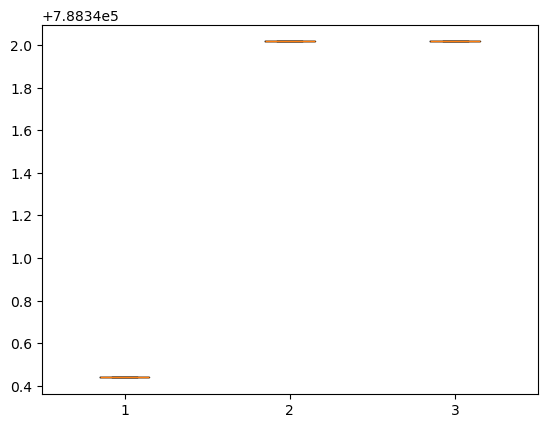

In [31]:
plt.boxplot(rmse_matrix[:][:][1])
plt.show()

In [32]:
print(rmse_matrix[0,:])

[[786914.48304325 786916.06199148 786916.06199148]
 [786914.48304325 786916.06199148 786916.06199148]
 [786914.48304325 786916.06199148 786916.06199148]]
